# TweetMine - Text mining tweets

An experimental notebook that retrieves tweets and analyzes it.

### Load tweets into a json file

In [1]:
import tweepy
import config 
import json
from tweepy import OAuthHandler

auth = OAuthHandler(config.consumer_key,config.consumer_secret)
auth.set_access_token(config.access_token,config.access_secret)
api = tweepy.API(auth)

num_tweets = 2000                    # number of tweets to retrieve
twitter_id = 'realDonaldTrump'     # userid 

file_name = 'trumptweets.json'
output = open(file_name,"w")
for tweet in tweepy.Cursor(api.user_timeline, id=twitter_id).items(num_tweets):
    output.write(json.dumps(tweet._json)+'\n') 
output.close()


### Parse json into a dataframe

In [2]:
import json
import pandas as pd 

def load_tweets(file):
    with open(file,'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()))
    return tweets

# Select the attributes needed
data = {'text': [], 'created_at': [], 'retweet_count': [], 'favorite_count': [], 'followers_count': []}
        
tweets = load_tweets(file_name)
for t in tweets:
    data['text'].append(t['text'])
    data['retweet_count'].append(t['retweet_count'])
    data['created_at'].append(t['created_at'])
    data['favorite_count'].append(t['favorite_count'])
    data['followers_count'].append(t['user']['followers_count'])
    
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(df['created_at']) # convert to datetime data type
df.sort_values(by='created_at'); # suppress output (works in notebook)

### Looking at Favorite and Retweet Counts

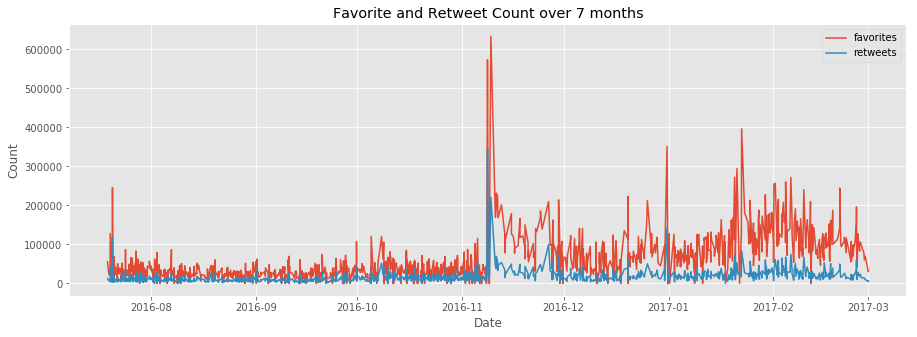

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize = (15,5))
num_days = (max(df['created_at']) - min(df['created_at'])).days
num_months = int(num_days/30)
plt.title('Favorite and Retweet Count over ' + str(num_months) + ' months')
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(df['created_at'],df['favorite_count'],label='favorite count')
plt.plot(df['created_at'],df['retweet_count'],label='retweet count')
plt.legend(['favorites','retweets'])
plt.show()

In [4]:
max_favorite_count = max(df['favorite_count'])
most_favorited_tweet = df.ix[df['favorite_count'].idxmax()]['text']

print("Donald Trump's most favorited tweet with " + str(max_favorite_count) + " tweets:\n" + most_favorited_tweet)

Donald Trump's most favorited tweet with 633591 tweets:
Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before


### Word Frequency

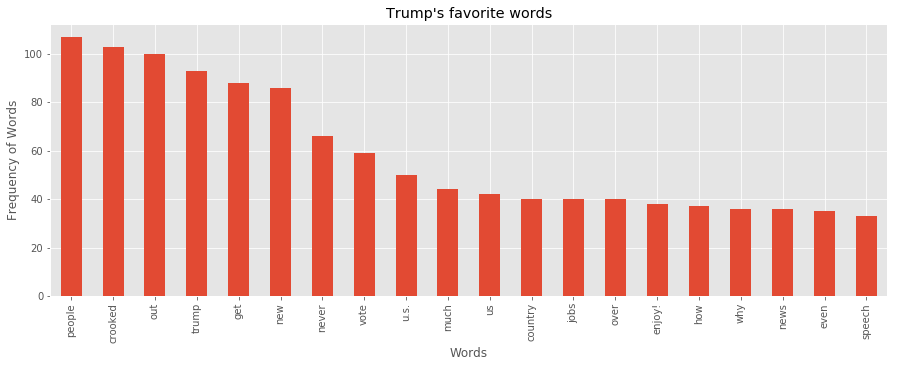

In [5]:
word_series = pd.Series(' '.join(df['text']).lower().split()) 
stop_words = ['the','is','of','at','to','be','and','in','a','will','for','on','with','i','you','we','our','my','it',
              '-','by','me','not','just','rt','so','very','she','from','who','her','but','no','or','he','up','would','should',
              'do']
filt  = list(filter(lambda word: not any(s in word for s in stop_words), word_series)) # filter stop words

plt.figure(figsize=(15,5))
plt.title("Trump's favorite words")

N = 20
word_freq = pd.Series(filt).value_counts()[:N]           # top N words
word_freq.plot(kind='bar')                               # how to rotate ticks?
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.show()

### Account Activity

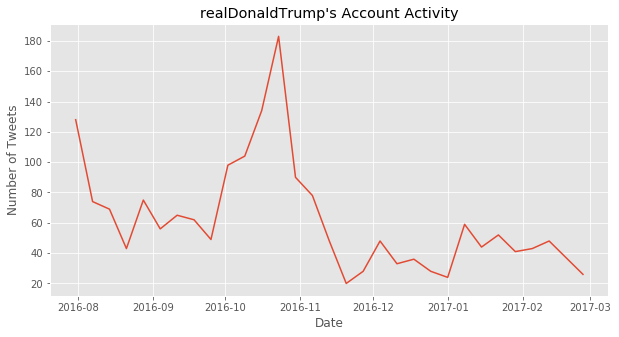

In [6]:
ind_df = df.set_index('created_at') 
ind_df = ind_df.groupby(pd.TimeGrouper(freq='W')).count().loc[:,'text'] # group by weeks, count, and extract a series
trim_df = ind_df.ix[1:len(ind_df)-1] # trim first/last week to ensure we show data collected from full weeks

plt.figure(figsize=(10,5))
plt.title(twitter_id + "'s Account Activity")
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.plot(trim_df)
plt.show()